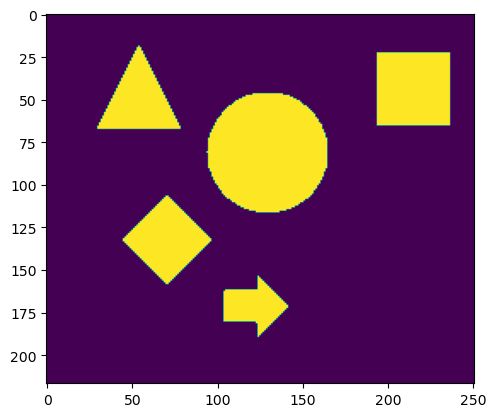

In [132]:
import cv2 
from matplotlib import pyplot as plt
import numpy as np

# originalImage = cv2.imread('yellowtargets.png')
originalImage = cv2.imread('geometric.png')
originalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_RGB2GRAY)
  
(thresh, binary_image) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)

plt.imshow(binary_image)

In [133]:
#TODO verify why threshold don't return real binary image
for row in range(binary_image.shape[0]):
    for col in range(binary_image.shape[1]):
        if binary_image[row][col] > 127:
            binary_image[row][col] = 1
        else:
            binary_image[row][col] = 0

Number of segments:  5


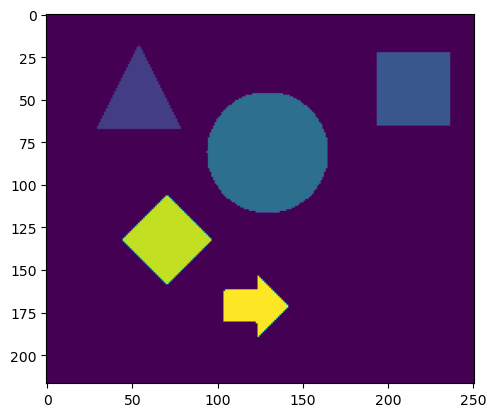

In [135]:
def connected_component(image):
    # Make copy of the image so we don't alter the original one
    image = image.copy()

    # Image pixels consist of 0 and 1's, let's start taging with two to simplify
    tag = 2
    
    hashmap = {}
    
    # First pass
    for row in range(1, image.shape[0]):
        for col in range(1, image.shape[1]):
            if image[row][col] == 1:
                neighbours = [image[row, col-1], image[row-1][col-1], image[row-1][col], image[row-1][col+1]]
                
                # Pixel not tagged, all neighbours are 0, create a new tag
                if neighbours == [0,0,0,0]:
                    image[row][col] = tag
                    tag += 1

                # We have one tagged neighbour, same tag
                elif neighbours.count(0) == 3:
                    image[row][col] = max(neighbours)

                # Multiples neighbours tagged
                else:
                    non_zero_neighbours = [i for i in neighbours if i != 0]
                    lowest = min(non_zero_neighbours)
                    image[row][col] = lowest

                    for temp_label in non_zero_neighbours:
                        if temp_label != lowest:
                            if lowest in hashmap:
                                hashmap[lowest].append(temp_label)
                                hashmap[lowest] = np.unique(hashmap[lowest]).tolist()
                            else:
                                hashmap[lowest] = [temp_label]

    # Rearange hashmap
    # we have a map like this {4: [5], 5: [6, 7], 6: [7, 8], 7: [8, 9], 8: [9], 11: [12]}
    # we need to transform to something like this {4: [5, 6, 7, 8, 9], 11: [12]}
    # and then to something like: {5:4, 6:4, 7:4, 8:4, 9:4, 12:11}
    # Flag to stop loop
    changed = True

    # In python we can't alter the size of a data structure while iterating it, keep this auxiliary list
    # to keep track of processed keys
    unprocessed_keys = [x for x in hashmap]

    while changed == True:
        changed = False

        for key, value in hashmap.items():
            if key in unprocessed_keys:
                for element in value: 
                    if element in unprocessed_keys:
                        hashmap[key] += hashmap[element]
                        unprocessed_keys.remove(element)
                        changed = True

    for key in hashmap.copy():
        if key not in unprocessed_keys:
           del hashmap[key] 
        else:
            hashmap[key] = np.unique(hashmap[key]).tolist() 

    new_map = {}
    for key, value in hashmap.items():
        for element in value:
            new_map[element] = key
    # Second pass
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            pixel = image[row][col]
            if pixel in new_map:
                image[row][col] = new_map[pixel]

    n_tags = len(np.unique(image)) - 1

    return n_tags, image
    
n_tags, new_image = connected_component(binary_image)

plt.imshow(new_image)
print('Number of segments: ', n_tags)